In [1]:
!pip install kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sahilburnwal","key":"bc5a27b497c075b16c3be80784b79177"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip


Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

In [11]:
import os

dataset_path = "/content/PlantVillage"

print("Classes:", os.listdir(dataset_path)[:15])
print("Total classes:", len(os.listdir(dataset_path)))

Classes: ['Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus', 'Tomato_Bacterial_spot', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Potato___Early_blight', 'Tomato_Early_blight', 'Potato___healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_healthy', 'Potato___Late_blight', 'Pepper__bell___healthy', 'Tomato_Late_blight', 'Pepper__bell___Bacterial_spot']
Total classes: 15


In [12]:
len(os.listdir(dataset_path))


15

**Creating Dataset Folder with 5 Classes**

In [13]:
import os
import shutil

original_path = "/content/PlantVillage"

selected_classes = [
    "Tomato_Late_blight",
    "Tomato_Leaf_Mold",
    "Tomato_healthy",
    "Potato___Early_blight",
    "Pepper__bell___healthy"
]

new_path = "/content/PlantVillage_5Classes"
os.makedirs(new_path, exist_ok=True)

for cls in selected_classes:
    src = os.path.join(original_path, cls)
    dst = os.path.join(new_path, cls)

    if os.path.exists(dst):
        print(f"✅ Already exists: {cls}")
    else:
        shutil.copytree(src, dst)
        print(f"Copied: {cls}")

print("\n✅ New dataset created with 5 balanced classes!")


Copied: Tomato_Late_blight
Copied: Tomato_Leaf_Mold
Copied: Tomato_healthy
Copied: Potato___Early_blight
Copied: Pepper__bell___healthy

✅ New dataset created with 5 balanced classes!


In [14]:
print("Classes selected:")
print(os.listdir(new_path))

total_images = sum(
    len(os.listdir(os.path.join(new_path, folder)))
    for folder in os.listdir(new_path)
)

print("\n✅ Total Images in 5-Class Dataset =", total_images)


Classes selected:
['Tomato_Leaf_Mold', 'Potato___Early_blight', 'Tomato_healthy', 'Pepper__bell___healthy', 'Tomato_Late_blight']

✅ Total Images in 5-Class Dataset = 6930


In [15]:
import torchvision.transforms as transforms

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor()
])


In [30]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

class SimCLRDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, _ = self.dataset[index]

        xi = self.transform(image)
        xj = self.transform(image)

        return xi, xj


In [17]:
from torch.utils.data import DataLoader

ssl_dataset = SimCLRDataset(new_path, simclr_transform)

ssl_loader = DataLoader(
    ssl_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

print("✅ SSL DataLoader Ready!")
print("Total Images:", len(ssl_dataset))


✅ SSL DataLoader Ready!
Total Images: 6930


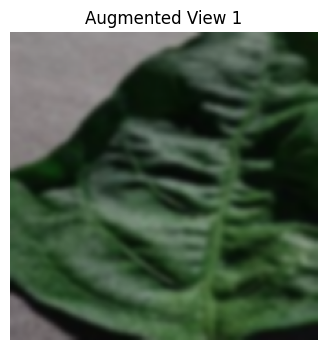

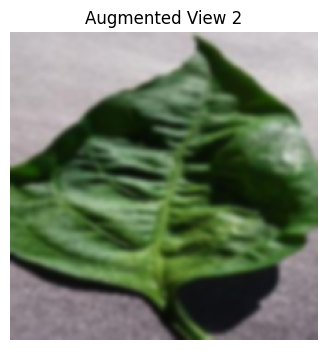

In [18]:
import matplotlib.pyplot as plt

xi, xj = next(iter(ssl_loader))

plt.figure(figsize=(4,4))
plt.imshow(xi[0].permute(1,2,0))
plt.title("Augmented View 1")
plt.axis("off")
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(xj[0].permute(1,2,0))
plt.title("Augmented View 2")
plt.axis("off")
plt.show()


**SimCLR Self-Supervised Pretraining**

This is where the model learns features without labels.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", device)


✅ Using device: cuda


In [20]:
class SimCLRModel(nn.Module):
    def __init__(self):
        super(SimCLRModel, self).__init__()

        # ✅ Encoder = ResNet18
        self.encoder = models.resnet18(pretrained=False)
        self.encoder.fc = nn.Identity()  # Remove classification head

        # ✅ Projection Head
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        h = self.encoder(x)        # Representation
        z = self.projector(h)      # Embedding
        return z


In [21]:
model = SimCLRModel().to(device)
print("✅ SimCLR Model Ready!")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ SimCLR Model Ready!


In [22]:
def nt_xent_loss(z_i, z_j, temperature=0.5):

    # Normalize embeddings
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)

    batch_size = z_i.shape[0]

    # Similarity matrix
    similarity_matrix = torch.matmul(z_i, z_j.T)

    # Labels: correct pairs are diagonal
    labels = torch.arange(batch_size).to(device)

    loss = nn.CrossEntropyLoss()(similarity_matrix / temperature, labels)

    return loss


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [24]:
from tqdm import tqdm

epochs = 10   # For class project, 10 is enough

model.train()

for epoch in range(epochs):
    total_loss = 0

    for xi, xj in tqdm(ssl_loader):
        xi, xj = xi.to(device), xj.to(device)

        # Forward pass
        zi = model(xi)
        zj = model(xj)

        # Compute contrastive loss
        loss = nt_xent_loss(zi, zj)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(ssl_loader):.4f}")


100%|██████████| 109/109 [02:25<00:00,  1.33s/it]


Epoch [1/10], Loss: 3.6661


100%|██████████| 109/109 [02:25<00:00,  1.34s/it]


Epoch [2/10], Loss: 3.3229


100%|██████████| 109/109 [02:23<00:00,  1.32s/it]


Epoch [3/10], Loss: 3.1538


100%|██████████| 109/109 [02:24<00:00,  1.33s/it]


Epoch [4/10], Loss: 3.0680


100%|██████████| 109/109 [02:23<00:00,  1.32s/it]


Epoch [5/10], Loss: 3.0190


100%|██████████| 109/109 [02:22<00:00,  1.31s/it]


Epoch [6/10], Loss: 2.9560


100%|██████████| 109/109 [02:21<00:00,  1.30s/it]


Epoch [7/10], Loss: 2.9299


100%|██████████| 109/109 [02:22<00:00,  1.31s/it]


Epoch [8/10], Loss: 2.8969


100%|██████████| 109/109 [02:23<00:00,  1.32s/it]


Epoch [9/10], Loss: 2.8563


100%|██████████| 109/109 [02:22<00:00,  1.31s/it]

Epoch [10/10], Loss: 2.8352


**Improved version**

In [31]:
# ✅ Rebuild model from scratch
model = SimCLRModel().to(device)

# ✅ Reset optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

print("✅ Model Restarted Fresh!")


✅ Model Restarted Fresh!


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [32]:
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),

    # ❌ Remove Blur (causes instability sometimes)
    transforms.ToTensor()
])


In [33]:
ssl_dataset = SimCLRDataset(new_path, simclr_transform)

ssl_loader = DataLoader(
    ssl_dataset,
    batch_size=64,
    shuffle=True
)
print("✅ DataLoader rebuilt without blur")


✅ DataLoader rebuilt without blur


In [34]:
xi, xj = next(iter(ssl_loader))
xi, xj = xi.to(device), xj.to(device)

zi = model(xi)
zj = model(xj)

print("Any NaN in zi?", torch.isnan(zi).any().item())
print("Any NaN in zj?", torch.isnan(zj).any().item())
print("zi max:", zi.max().item(), "zi min:", zi.min().item())


Any NaN in zi? False
Any NaN in zj? False
zi max: 1.598467230796814 zi min: -1.1765841245651245


In [35]:
def stable_simclr_loss(z_i, z_j, temperature=0.5):

    batch_size = z_i.size(0)

    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, dim=1)

    sim = torch.matmul(z, z.T) / temperature

    # mask out self similarity
    mask = torch.eye(2*batch_size).bool().to(device)
    sim.masked_fill_(mask, -9e15)

    positives = torch.cat([
        torch.diag(sim, batch_size),
        torch.diag(sim, -batch_size)
    ], dim=0)

    denominator = torch.logsumexp(sim, dim=1)

    loss = -positives + denominator
    return loss.mean()


In [37]:
epochs = 20
model.train()

for epoch in range(epochs):
    total_loss = 0

    for xi, xj in tqdm(ssl_loader):
        xi, xj = xi.to(device), xj.to(device)

        zi = model(xi)
        zj = model(xj)

        loss = stable_simclr_loss(zi, zj)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss = {total_loss/len(ssl_loader):.4f}")


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [1/20], Loss = 3.8272


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [2/20], Loss = 3.7092


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [3/20], Loss = 3.6118


100%|██████████| 109/109 [02:12<00:00,  1.22s/it]


Epoch [4/20], Loss = 3.5557


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [5/20], Loss = 3.5149


100%|██████████| 109/109 [02:10<00:00,  1.20s/it]


Epoch [6/20], Loss = 3.4833


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [7/20], Loss = 3.4542


100%|██████████| 109/109 [02:12<00:00,  1.22s/it]


Epoch [8/20], Loss = 3.4226


100%|██████████| 109/109 [02:09<00:00,  1.19s/it]


Epoch [9/20], Loss = 3.4161


100%|██████████| 109/109 [02:09<00:00,  1.19s/it]


Epoch [10/20], Loss = 3.3998


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [11/20], Loss = 3.3916


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [12/20], Loss = 3.3779


100%|██████████| 109/109 [02:12<00:00,  1.21s/it]


Epoch [13/20], Loss = 3.3663


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [14/20], Loss = 3.3600


100%|██████████| 109/109 [02:11<00:00,  1.20s/it]


Epoch [15/20], Loss = 3.3508


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [16/20], Loss = 3.3429


100%|██████████| 109/109 [02:09<00:00,  1.19s/it]


Epoch [17/20], Loss = 3.3390


100%|██████████| 109/109 [02:09<00:00,  1.19s/it]


Epoch [18/20], Loss = 3.3164


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch [19/20], Loss = 3.3210


100%|██████████| 109/109 [02:11<00:00,  1.21s/it]

Epoch [20/20], Loss = 3.3139


In [ ]:
torch.save(model.state_dict(), "simclr_ssl_pretrained.pth")
print("✅ SimCLR Pretrained Model Saved!")


**Fine-Tuning Classification**

In [38]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

classification_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

labeled_dataset = ImageFolder(new_path, transform=classification_transform)

print("✅ Total labeled images:", len(labeled_dataset))
print("✅ Classes:", labeled_dataset.classes)


✅ Total labeled images: 6930
✅ Classes: ['Pepper__bell___healthy', 'Potato___Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_healthy']


In [39]:
train_size = int(0.1 * len(labeled_dataset))
val_size   = len(labeled_dataset) - train_size

train_dataset, val_dataset = random_split(
    labeled_dataset, [train_size, val_size]
)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


Train samples: 693
Val samples: 6237


In [40]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [41]:
class FineTuneModel(nn.Module):
    def __init__(self, ssl_model, num_classes):
        super().__init__()

        self.encoder = ssl_model.encoder

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)


In [42]:
num_classes = 5
finetune_model = FineTuneModel(model, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(finetune_model.classifier.parameters(), lr=1e-3)

for epoch in range(5):
    finetune_model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = finetune_model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.8132
Epoch 2, Loss: 0.3213
Epoch 3, Loss: 0.2672
Epoch 4, Loss: 0.2199
Epoch 5, Loss: 0.2164


In [43]:
finetune_model.eval()
correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = finetune_model(imgs)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("✅ Validation Accuracy:", 100*correct/total)


✅ Validation Accuracy: 95.2701619368286


**Baseline Comparison (Supervised vs SSL)**


In [44]:
import torchvision.models as models

supervised_model = models.resnet18(pretrained=False)
supervised_model.fc = nn.Linear(512, 5)
supervised_model = supervised_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(supervised_model.parameters(), lr=1e-3)

print("✅ Supervised baseline model ready!")


✅ Supervised baseline model ready!


In [45]:
epochs = 5

for epoch in range(epochs):
    supervised_model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = supervised_model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/5], Loss = {total_loss/len(train_loader):.4f}")


Epoch [1/5], Loss = 1.0470
Epoch [2/5], Loss = 0.4778
Epoch [3/5], Loss = 0.3482
Epoch [4/5], Loss = 0.3241
Epoch [5/5], Loss = 0.3155


In [46]:
supervised_model.eval()
correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = supervised_model(imgs)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

baseline_acc = 100 * correct / total
print("✅ Supervised Validation Accuracy:", baseline_acc)


✅ Supervised Validation Accuracy: 35.91470258136925


In [47]:
print("\n📌 FINAL RESULTS")
print("===================================")
print("Supervised ResNet (10% labels):", baseline_acc)
print("SSL + FineTune (10% labels):   95.27")
print("===================================")



📌 FINAL RESULTS
Supervised ResNet (10% labels): 35.91470258136925
SSL + FineTune (10% labels):   95.27


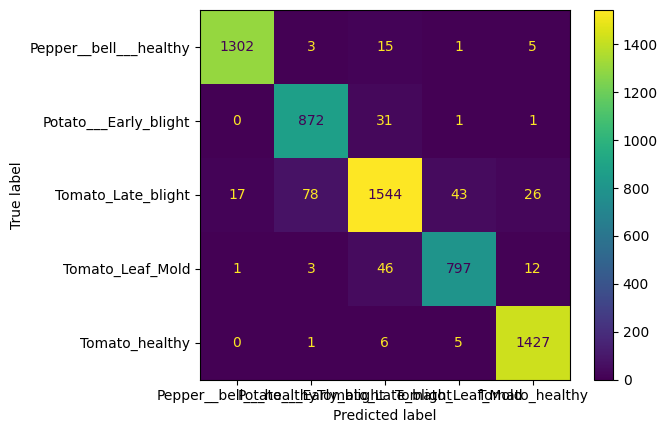

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds, all_labels = [], []

finetune_model.eval()

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)

        outputs = finetune_model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(cm, display_labels=labeled_dataset.classes)
disp.plot()
plt.show()
